In [1]:
import sys
sys.path.append('C:/Users/juans/OneDrive/Documentos/iaProyect/Cognitive')
print(sys.path)  # Esto mostrará todas las rutas en sys.path


['C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\python311.zip', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\DLLs', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\\Lib', 'C:\\Program Files\\WindowsApps\\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv', '', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\win32', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\juans\\OneDrive\\Documentos\\iaProyect\\Cognitive\\.venv\\Lib\\site-packages\\Pythonwin', 'C:/Users/juans/OneDrive/Documentos/iaProyect/Cognitive']


In [2]:
import numpy as np
import time
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from xgboost import XGBClassifier
from model.preprocessing.data_extraction import DataExtractor
from model.utils.tensorboard import get_tensorboard_writer
import json
from bayes_opt import BayesianOptimization

class ModelTrainer:
    def __init__(self, dataFolderFile: str = "preprocessed_data.pkl", labelsName: str = "Deterioro Cognitivo"):
        self.dataExtractor = DataExtractor()
        self.data = self.dataExtractor.load_data_pickle(dataFolderFile)
        separated_data = self.dataExtractor.extract_test_validation_training_data(self.data, labelsName)
        self.X_train, self.y_train = separated_data['training']
        self.X_test, self.y_test = separated_data['test']
        self.X_validation, self.y_validation = separated_data['validation']
        self.writer = get_tensorboard_writer('../logs/fit/')
        self.model = None

    def build_model(self):
        base_models = [
            ('random_forest', RandomForestClassifier(random_state=42)),
            ('xgboost', XGBClassifier(eval_metric='logloss', random_state=42))
        ]
        final_estimator = LogisticRegression()
        self.model = StackingClassifier(
            estimators=base_models, final_estimator=final_estimator, cv=StratifiedKFold(n_splits=5))
        self.writer.add_text('Model_Structure', str(self.model))

    def optimize_hyperparameters(self):
        def objective(n_estimators, max_depth, learning_rate):
            model = StackingClassifier(
                estimators=[
                    ('random_forest', RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)),
                    ('xgboost', XGBClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, max_depth=int(max_depth), random_state=42))
                ],
                final_estimator=LogisticRegression(),
                cv=StratifiedKFold(n_splits=3)
            )
            score = cross_val_score(model, self.X_validation, self.y_validation, cv=2, scoring='roc_auc_ovr').mean()
            self.writer.add_scalar('Objective_Function', score)
            return score

        optimizer = BayesianOptimization(
            f=objective,
            pbounds={
                'n_estimators': (200, 1000),
                'max_depth': (10, 50),
                'learning_rate': (0.001, 0.2)
            },
            random_state=42
        )
        optimizer.maximize(init_points=2, n_iter=10)  # Más puntos iniciales e iteraciones
        best_params = optimizer.max['params']
        self.model.set_params(
            random_forest__n_estimators=int(best_params['n_estimators']),
            random_forest__max_depth=int(best_params['max_depth']),
            xgboost__n_estimators=int(best_params['n_estimators']),
            xgboost__learning_rate=best_params['learning_rate'],
            xgboost__max_depth=int(best_params['max_depth'])
        )
        self.writer.add_text('Optimized_Hyperparameters', json.dumps(best_params, indent=4))

    def train_model(self):
        start_time = time.time()
        self.model.fit(self.X_train, self.y_train)
        duration = time.time() - start_time

        # Evaluando la precisión en entrenamiento
        train_accuracy = accuracy_score(self.y_train, self.model.predict(self.X_train))
        self.writer.add_scalar('Training_Time', duration)
        self.writer.add_scalar('Training_Accuracy', train_accuracy)

        # Agregar registro de precisión en conjunto de validación y test
        validation_accuracy = self.model.score(self.X_validation, self.y_validation)
        test_accuracy = self.model.score(self.X_test, self.y_test)
        self.writer.add_scalar('Validation_Accuracy', validation_accuracy)
        self.writer.add_scalar('Test_Accuracy', test_accuracy)

        # Registrando el tiempo total hasta ahora y la precisión asociada
        total_time = time.time() - start_time
        self.writer.add_scalar('Total_Training_Time_vs_Accuracy', train_accuracy, total_time)


    def validate_model(self):
        accuracy_scores = []
        for i in range(30):
            resample_idx = np.random.choice(self.X_validation.index, size=len(self.X_validation), replace=True)
            X_resample = self.X_validation.loc[resample_idx]
            y_resample = self.y_validation.loc[resample_idx]
            score = self.model.score(X_resample, y_resample)
            accuracy_scores.append(score)
            self.writer.add_scalar('Bootstrap_Validation_Accuracy', score, i)
        mean_accuracy = np.mean(accuracy_scores)
        self.writer.add_scalar('Mean_Bootstrap_Validation_Accuracy', mean_accuracy)

    def run(self):
        self.build_model()
        self.optimize_hyperparameters()
        self.train_model()
        self.validate_model()
        self.writer.close()




In [4]:
trainer = ModelTrainer()
trainer.run()


|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.9957    | 0.07553   | 48.03     | 785.6     |
| 2         | 0.996     | 0.1201    | 16.24     | 324.8     |
| 3         | 0.9961    | 0.1418    | 18.03     | 326.8     |
| 4         | 0.9961    | 0.03536   | 24.72     | 329.5     |
| 5         | 0.9961    | 0.03208   | 15.82     | 337.3     |
| 6         | 0.9961    | 0.106     | 27.83     | 344.4     |
| 7         | 0.9949    | 0.003603  | 18.45     | 351.0     |
| 8         | 0.9962    | 0.09895   | 35.99     | 338.4     |
| 9         | 0.996     | 0.08518   | 41.18     | 348.9     |
| 10        | 0.9961    | 0.1954    | 42.33     | 326.0     |
| 11        | 0.9961    | 0.02685   | 49.89     | 336.5     |
| 12        | 0.9963    | 0.1671    | 33.75     | 314.5     |


Index(['Edad', 'Autopercepcin Salud', 'Estado Civil', 'Escolaridad',
       'Ocupacin', 'Tipo problema auditivo', 'Tipo problema visuales',
       'Tipo enfermedad psiquitrica', 'Antecedentes Familiares Otros',
       'Lawton Pre Usar Telefono', 'Lawton Act Manejar Dinero',
       'Lawton Act Trabajo Pesado Casa', 'Total Lawton Actual Con Dificultad',
       'Total Gds', 'Cdr Memoria', 'Cdr Juicio', 'Cdr Vida Social',
       'Cdr Hogar Y Aficiones', 'Total Cdr', 'Mdico Atencin'],
      dtype='object')
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       228
           1       1.00      0.96      0.98        45
           2       1.00      1.00      1.00         7

    accuracy                           0.99       280
   macro avg       1.00      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280



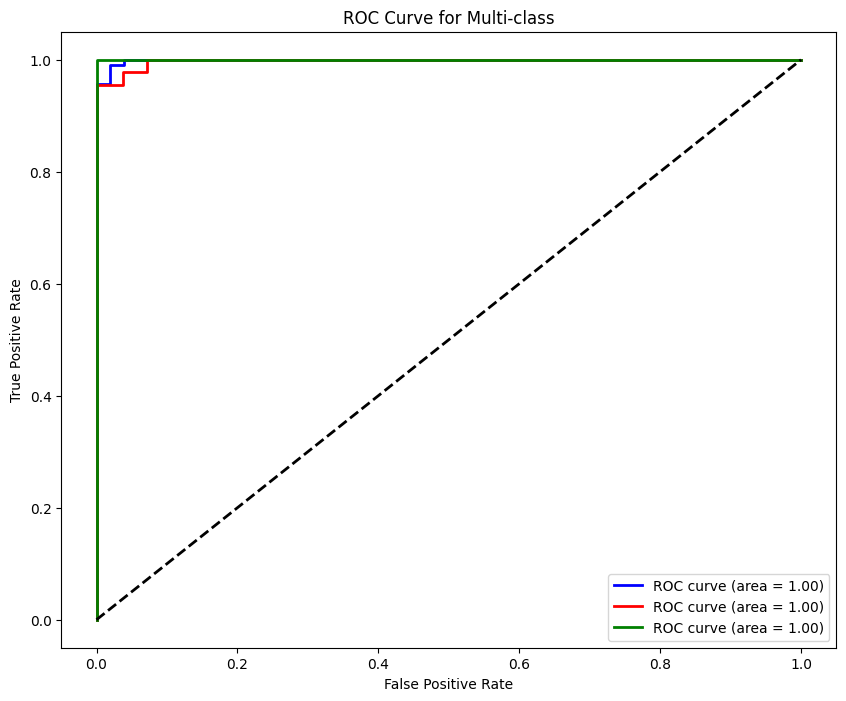

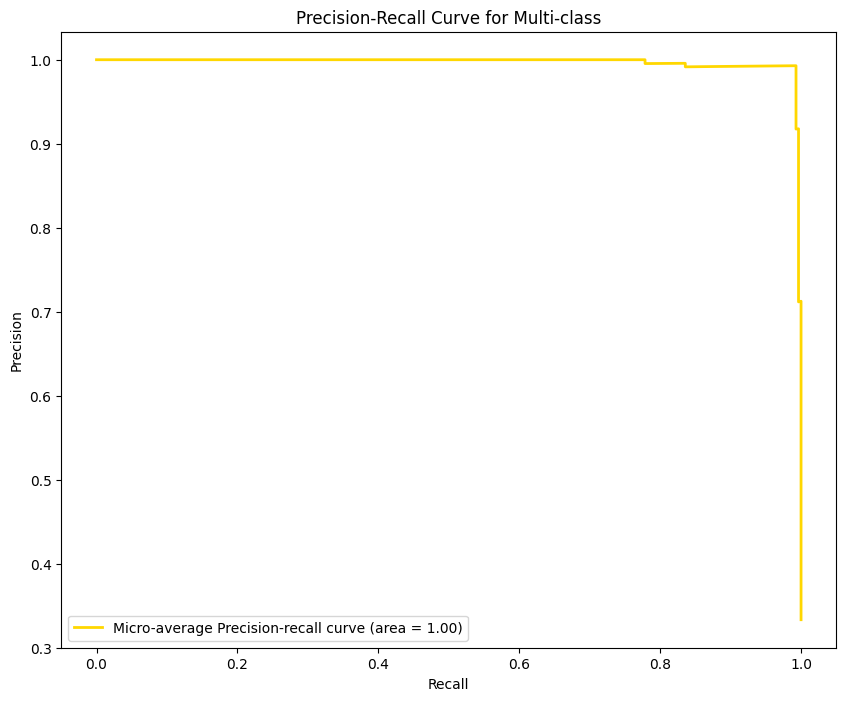

F1 Score: {f1:.2f}


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.preprocessing import label_binarize
from itertools import cycle


class ModelMetrics:
    def __init__(self, model, X_test, y_test, n_classes):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.n_classes = n_classes
        self.y_pred = model.predict(X_test)
        self.y_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    def print_classification_report(self):
        print("Classification Report:\n", classification_report(self.y_test, self.y_pred))

    def plot_roc_curve(self):
        y_test_bin = label_binarize(self.y_test, classes=[*range(self.n_classes)])
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(self.n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], self.y_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(10, 8))
        colors = cycle(['blue', 'red', 'green', 'yellow', 'orange'])
        for i, color in zip(range(self.n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Multi-class')
        plt.legend(loc="lower right")
        plt.show()

    def plot_precision_recall_curve(self):
        y_test_bin = label_binarize(self.y_test, classes=[*range(self.n_classes)])
        precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), self.y_proba.ravel())
        plt.figure(figsize=(10, 8))
        plt.plot(recall, precision, color='gold', lw=2,
                 label='Micro-average Precision-recall curve (area = {0:0.2f})'.format(auc(recall, precision)))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve for Multi-class')
        plt.legend(loc="best")
        plt.show()

    def print_f1_score(self):
        f1 = f1_score(self.y_test, self.y_pred, average='macro')  # Usando 'macro' para considerar todas las clases
        print("F1 Score: {f1:.2f}")

# Ejemplo de cómo utilizar esta clase:
# Supón que ya has cargado tus datos y entrenado tu modelo, entonces puedes hacer lo siguiente:
data = trainer.data
new_X_test = trainer.X_test
new_y_test = trainer.y_test
n_classes = len(np.unique(new_y_test))

print(new_X_test.columns)

metrics = ModelMetrics(trainer.model, new_X_test, new_y_test, n_classes)
metrics.print_classification_report()
metrics.plot_roc_curve()
metrics.plot_precision_recall_curve()
metrics.print_f1_score()
